[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JinmiaoChenLab/DISCOtoolkit_py/blob/main/docs/download_data.ipynb)
# Download Data

We recommend the user visit our [DISCO](http://www.immunesinglecell.org/) website and filter the sample based on the metadata provided on the website.

In this tutorial, we will provide a quick guideline for downloading the data using discotoolkit.
Steps:
- Visit the website to find a sample or cell type of interest.
- Utilize the `dt.filter_disco_metadata` function to filter the data from the database.
- Employ the `dt.download_disco_data` function to download the data in the `h5ad` extension based on the filtered sample.

In [1]:
# for google colab
# pip install discotoolkit
# first import the installed package
import discotoolkit as dt
import os
import scanpy as sc
import anndata as ad
import re
import matplotlib.pyplot as plt

# adding ignore warning to clean the code
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# setting params for the visualisation
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# Set the plotting backend to 'umap-learn' for interactive plot
sc.settings.plotting_backend = 'umap-learn'

For this example, we wanted to download LYVE1 macrophage from lung tissue as our cell type of interest. We subset only the highly confident cell type prediction based on our manual annotation and the minimum 300 cells per sample. Notice that we specify `include_cell_type_children` as true to include all sub-cell types if applicable.

In [3]:
# filtering the sample based on the metadata
filter = dt.Filter(
    sample = None,
    project = None,
    tissue = "lung",
    platform = ["10x3'", "10x5'"],
    sample_type = ["Normal", "Adjacent normal"],
    cell_type = "LYVE1 macrophage",
    cell_type_confidence = "high",
    include_cell_type_children = True,
    min_cell_per_sample = 300
)

In [4]:
# apply the filter of interest
metadata = dt.filter_disco_metadata(filter)

INFO:root:Retrieving metadata from DISCO database
INFO:root:Filtering sample
INFO:root:Retrieving cell type information of each sample from DISCO database
INFO:root:Retrieving ontology from DISCO database
INFO:root:8 samples and 3863 cells were found


After applying the filter to the database, now we can download the dataset into the `disco_data` directory.

In [5]:
# download data to the local directory
dir_path = "disco_data"
download_log = dt.download_disco_data(metadata, output_dir = dir_path)

INFO:root:Downloading data of GSM3891625_3
INFO:root:Downloading data of GSM5068934_9
INFO:root:Downloading data of GSM5068933_11
INFO:root:Downloading data of GSM5068932_8
INFO:root:Downloading data of GSM5068924_9
INFO:root:Downloading data of GSM5068929_11
INFO:root:Downloading data of GSM5068929_16
INFO:root:Downloading data of GSM5068936_4
INFO:root:Downloading data of GSM5068928_12


We can check to see if the files have been download successfully using `os` library with function `listdir()`

In [6]:
# double checking to see if the files have been download successf
os.listdir(dir_path)

['GSM5068933_11.h5ad',
 'GSM5068929_16.h5ad',
 'GSM5068928_12.h5ad',
 'GSM5068929_11.h5ad',
 'GSM5068932_8.h5ad',
 'GSM5068934_9.h5ad',
 'GSM3891625_3.h5ad',
 'GSM5068924_9.h5ad',
 'GSM5068936_4.h5ad']

Since the data has been successfully downloaded, we can then use the `scanpy` library to visualize the UMAP of the downloaded data. This can be achieved by concatenating the files in the downloaded directory into one combined `anndata`. The combined `anndata` is useful for downstream analysis or integration, enabling further study of the scRNA-seq.

In [7]:
directory = 'disco_data'
adata_list = []

# Read and store datasets
for filename in os.listdir(directory):
    if filename.endswith('.h5ad'):
        filepath = os.path.join(directory, filename)
        adata = sc.read(filepath)

        # Rename columns with periods in `.obs` attribute
        for col in adata.obs.columns:
            new_col = re.sub(r'\.', '_', col)
            adata.obs.rename(columns={col: new_col}, inplace=True)

        # Rename columns with periods in `.var` attribute
        for col in adata.var.columns:
            new_col = re.sub(r'\.', '_', col)
            adata.var.rename(columns={col: new_col}, inplace=True)

        del adata.raw

        adata_list.append(adata)
        
# Concatenate the datasets
combined_adata = ad.concat(adata_list)

# making the obs name unique
combined_adata.obs_names_make_unique()

# Print the concatenated dataset
print(combined_adata)

AnnData object with n_obs × n_vars = 3863 × 33538
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'RNA_snn_res_0_8', 'seurat_clusters', 'cell_type', 'cell_type_score', 'sampling_weight'
    obsm: 'X_pca', 'X_umap'


... storing 'cell_type' as categorical


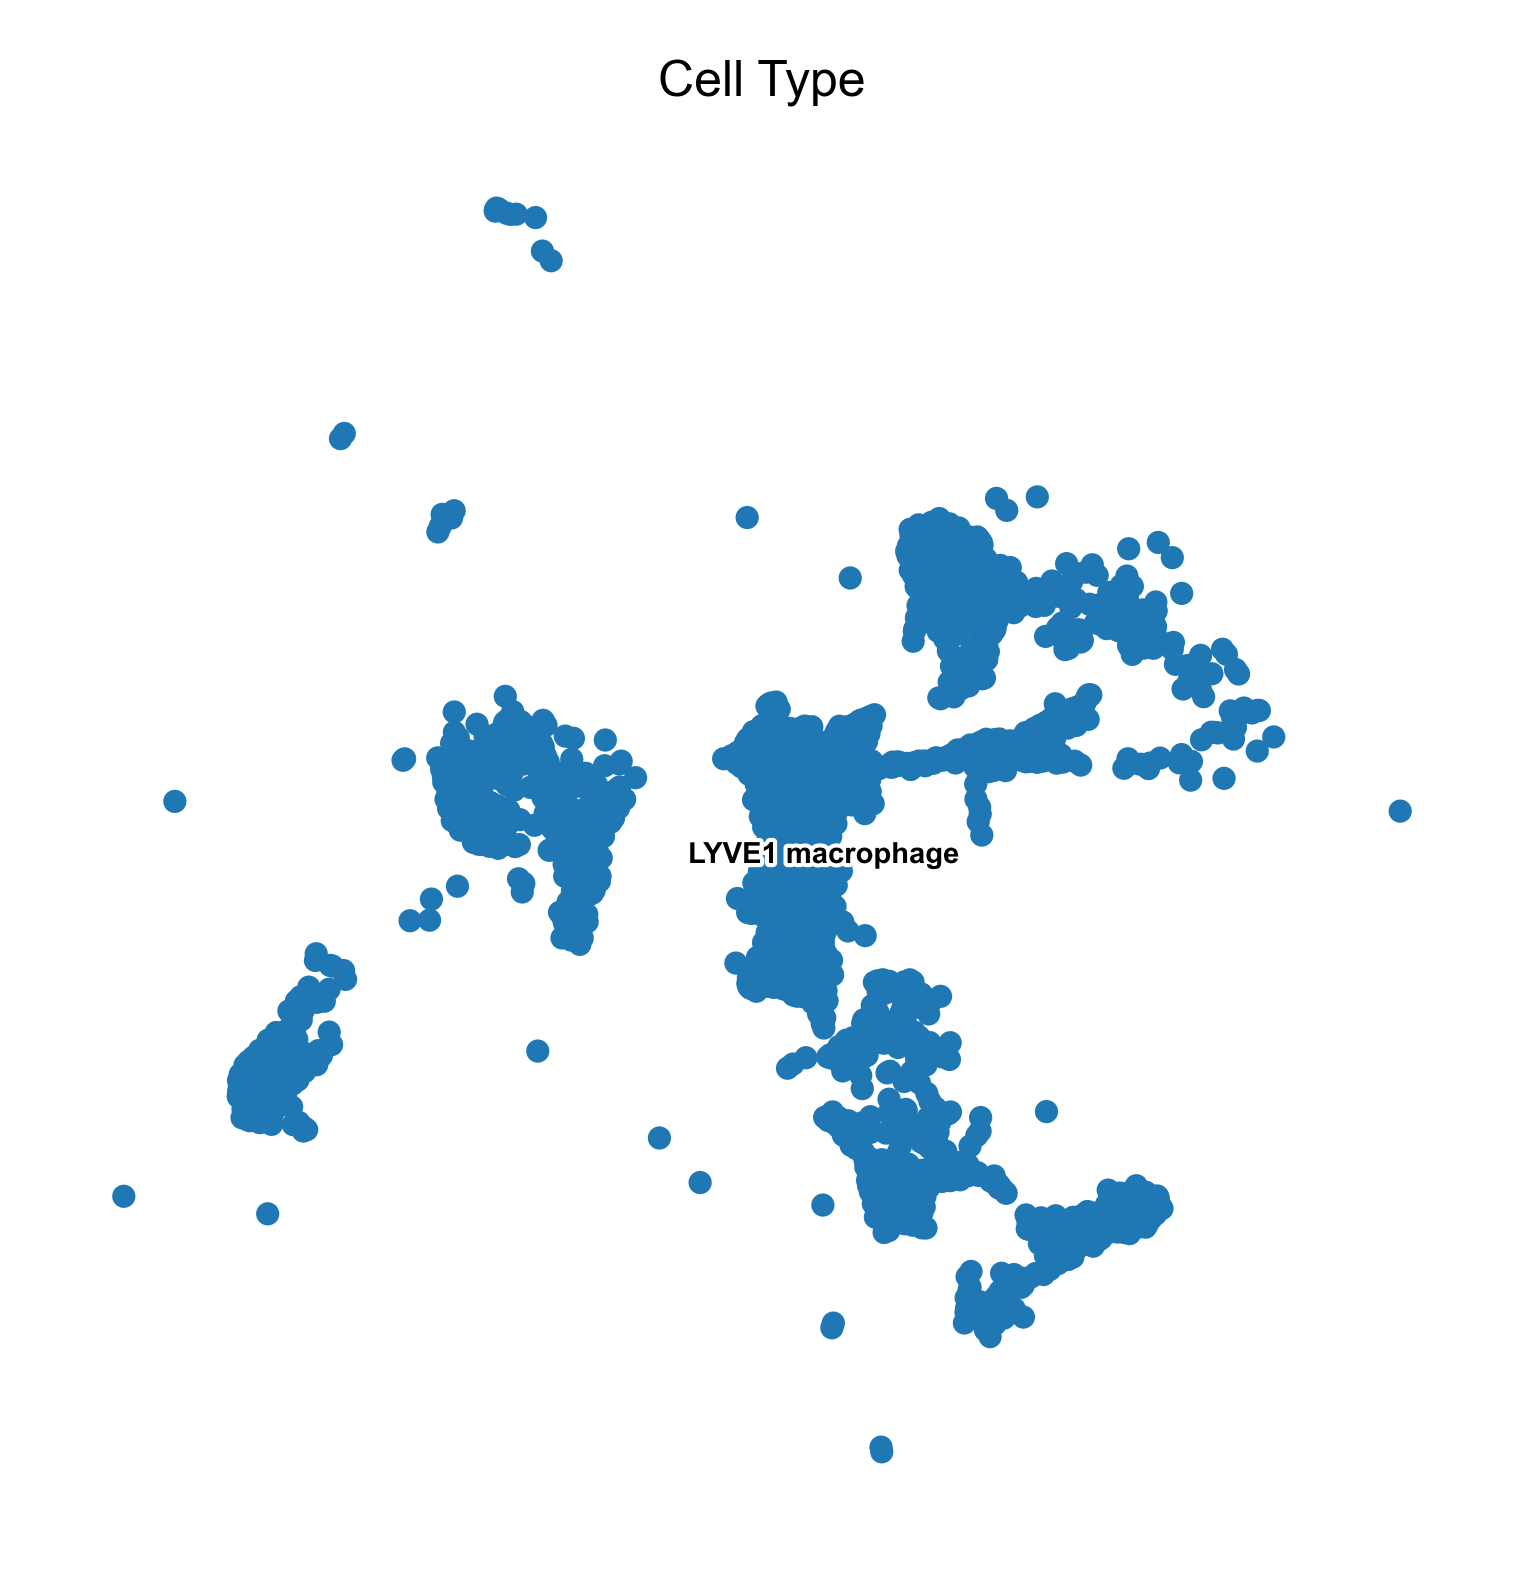

In [8]:
# Generate the UMAP plot
ax = sc.pl.umap(combined_adata, color='cell_type', legend_loc='on data',
           frameon=False, legend_fontsize=3.5, legend_fontoutline=1, show=False)

# Set the plot title with the desired font size
ax.set_title('Cell Type', fontsize=6)

# Show the plot
plt.show()

Great! We have successfully filtered and downloaded the cell type-specific data from the DISCO database.